In [1]:
import importlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyswarms.utils.plotters import plot_cost_history
from sklearn.cluster import KMeans

import src.SI as SI
importlib.reload(SI)

<module 'src.SI' from 'c:\\Users\\seppe\\OneDrive\\Desktop\\Cursussen\\Big Data Algorithms\\Project\\BDA-project\\notebooks\\src\\SI.py'>

## Data

In [2]:
data_points = pd.read_csv('data/iris/iris.txt', sep=',', header=None)
labels = data_points[4].values
data_points = data_points.drop([4], axis=1)

label_map = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}
numeric_labels = np.vectorize(label_map.get)(labels).astype(np.int32)

The [iris](https://doi.org/10.1111/j.1469-1809.1936.tb02137.x) dataset consists of 150 samples from three species of the Iris flower (Iris setosa, Iris versicolor, and Iris virginica), with four features measured for each sample: sepal length, sepal width, petal length, and petal width, all in centimeters.

K-Means++ and three swarm algorithms will be applied on this dataset. The results will be evaluated using the accuracy to the ground truth labels, the adjusted rand score for the similarity between the resulting clustering and the true clustering and the silhouette score for quality of the clustering.

## Clustering

In [3]:
input_data = data_points
true_labels = numeric_labels
n_clusters = 3

results = pd.DataFrame(columns=['Accuracy Score', "Adjusted Rand Score", "Silhouette Score"])

In [4]:
# Code to translate arbitrary predicted labels to match ground truth labels
from munkres import Munkres

def make_cost_matrix(c1, c2):
    uc1, uc2 = np.unique(c1), np.unique(c2)
    assert uc1.size == uc2.size and np.all(uc1 == uc2)

    m = np.ones([uc1.size, uc2.size])
    for i, val_i in enumerate(uc1):
        it_i = np.nonzero(c1 == val_i)[0]
        for j, val_j in enumerate(uc2):
            it_j = np.nonzero(c2 == val_j)[0]
            m[i, j] = -np.intersect1d(it_i, it_j).size
    return m

def translate_predicted_labels(predicted_y, y):
    cost_matrix = make_cost_matrix(predicted_y, y)
    indexes = Munkres().compute(cost_matrix)
    mapper = {old: new for (old, new) in indexes}
    
    for old, new in mapper.items():
        print(f"Mapping cluster {old} → Class {new}")

    return np.array([mapper[i] for i in predicted_y])

### Old analysis

In [5]:
# Run K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(input_data)

kmeans_centers = kmeans.cluster_centers_

In [6]:
translated_kmeans_labels = translate_predicted_labels(kmeans_labels, true_labels)
results.loc["K-Means"] = SI.evaluate_labels(input_data, true_labels, translated_kmeans_labels)

Mapping cluster 0 → Class 2
Mapping cluster 1 → Class 0
Mapping cluster 2 → Class 1


### Swarm algorithms

In [7]:
iters = 1000

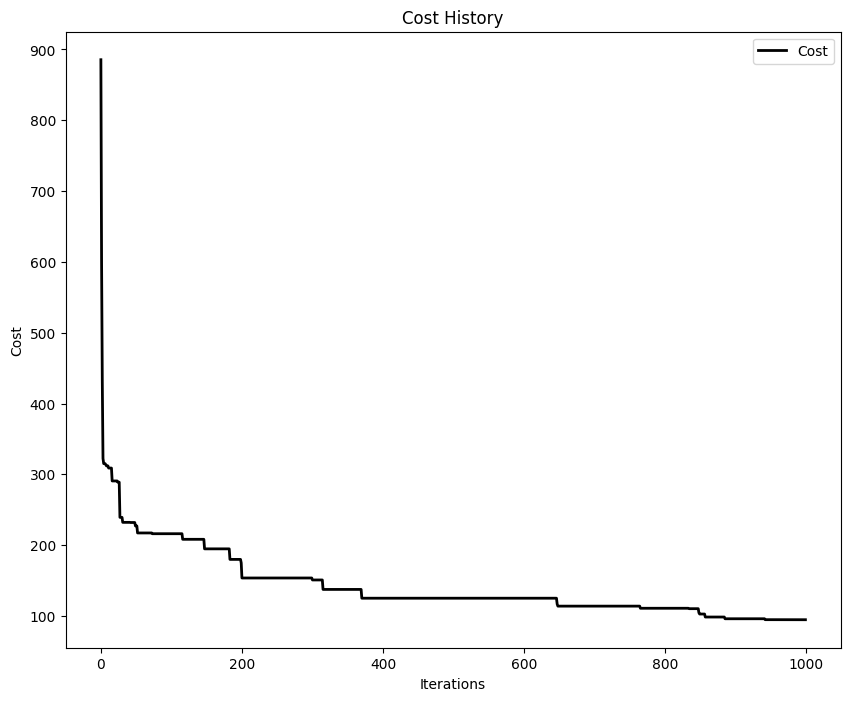

In [8]:
# Run PSO
pso_cost, pso_centers, pso_labels, pso_pos_history, pso_cost_history, pso_best_centers_history = SI.run_pso(input_data, n_clusters, iters, n_particles=30, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}, record_history=True)

plot_cost_history(cost_history=pso_cost_history)
plt.show()

In [9]:
translated_pso_labels = translate_predicted_labels(pso_labels, true_labels)
results.loc["PSO"] = SI.evaluate_labels(input_data, true_labels, translated_pso_labels)

Mapping cluster 0 → Class 0
Mapping cluster 1 → Class 2
Mapping cluster 2 → Class 1


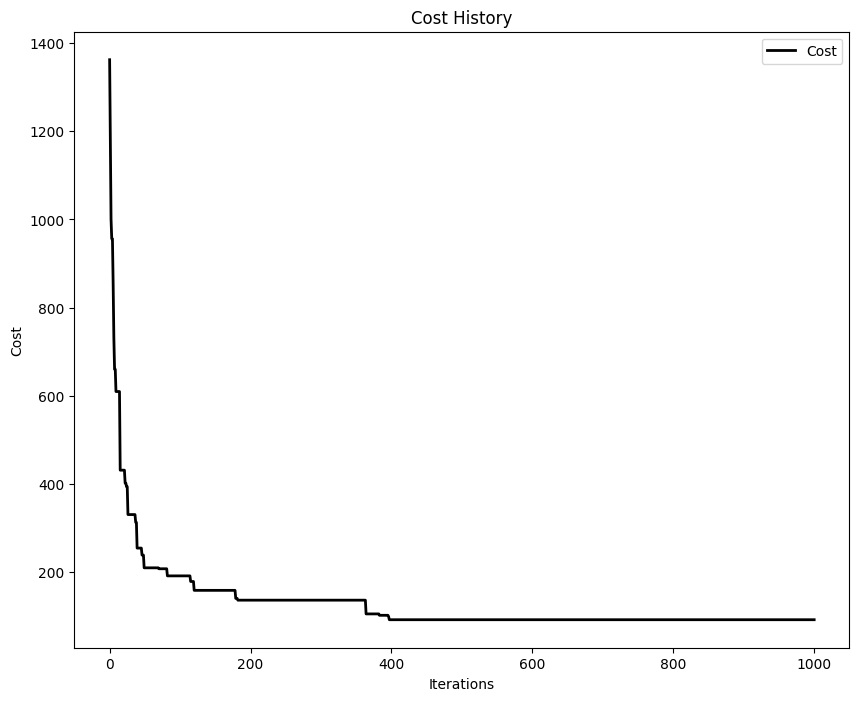

In [10]:
# Run ABC
abc_cost, abc_centers, abc_labels, abc_history = SI.run_abc(
    input_data, n_clusters=n_clusters, iters=iters, n_food_sources=30, limit=20, record_history=True
)

plot_cost_history(cost_history=abc_history["costs"])
plt.show()

In [11]:
translated_abc_labels = translate_predicted_labels(abc_labels, true_labels)
results.loc["ABC"] = SI.evaluate_labels(input_data, true_labels, translated_abc_labels)

Mapping cluster 0 → Class 1
Mapping cluster 1 → Class 2
Mapping cluster 2 → Class 0


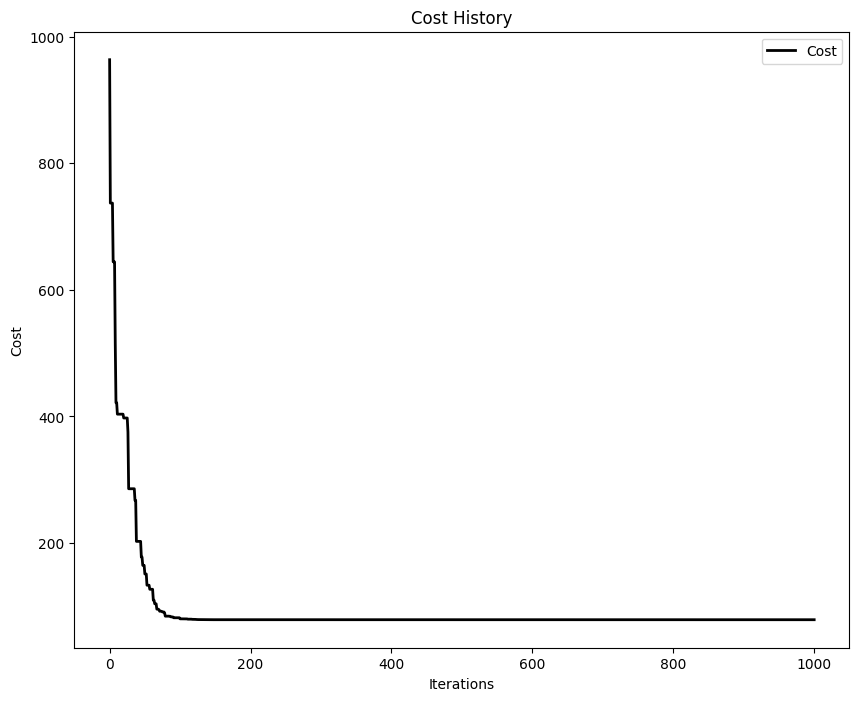

In [12]:
# Run ACOR (ACO variant)
acor_cost, acor_centers, acor_labels, acor_history = SI.run_acor(
    input_data, n_clusters=n_clusters, iters=iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True
)

plot_cost_history(cost_history=acor_history["costs"])
plt.show()

In [13]:
translated_acor_labels = translate_predicted_labels(acor_labels, true_labels)
results.loc["ACOR"] = SI.evaluate_labels(input_data, true_labels, translated_acor_labels)

Mapping cluster 0 → Class 2
Mapping cluster 1 → Class 1
Mapping cluster 2 → Class 0


## Results

In [14]:
results.head()

,Accuracy Score,Adjusted Rand Score,Silhouette Score
K-Means,0.887,0.716,0.551
PSO,0.893,0.731,0.520
ABC,0.907,0.758,0.520
ACOR,0.893,0.730,0.553


For this dataset, swarm algorithms give a slightly better result than K-Means++.

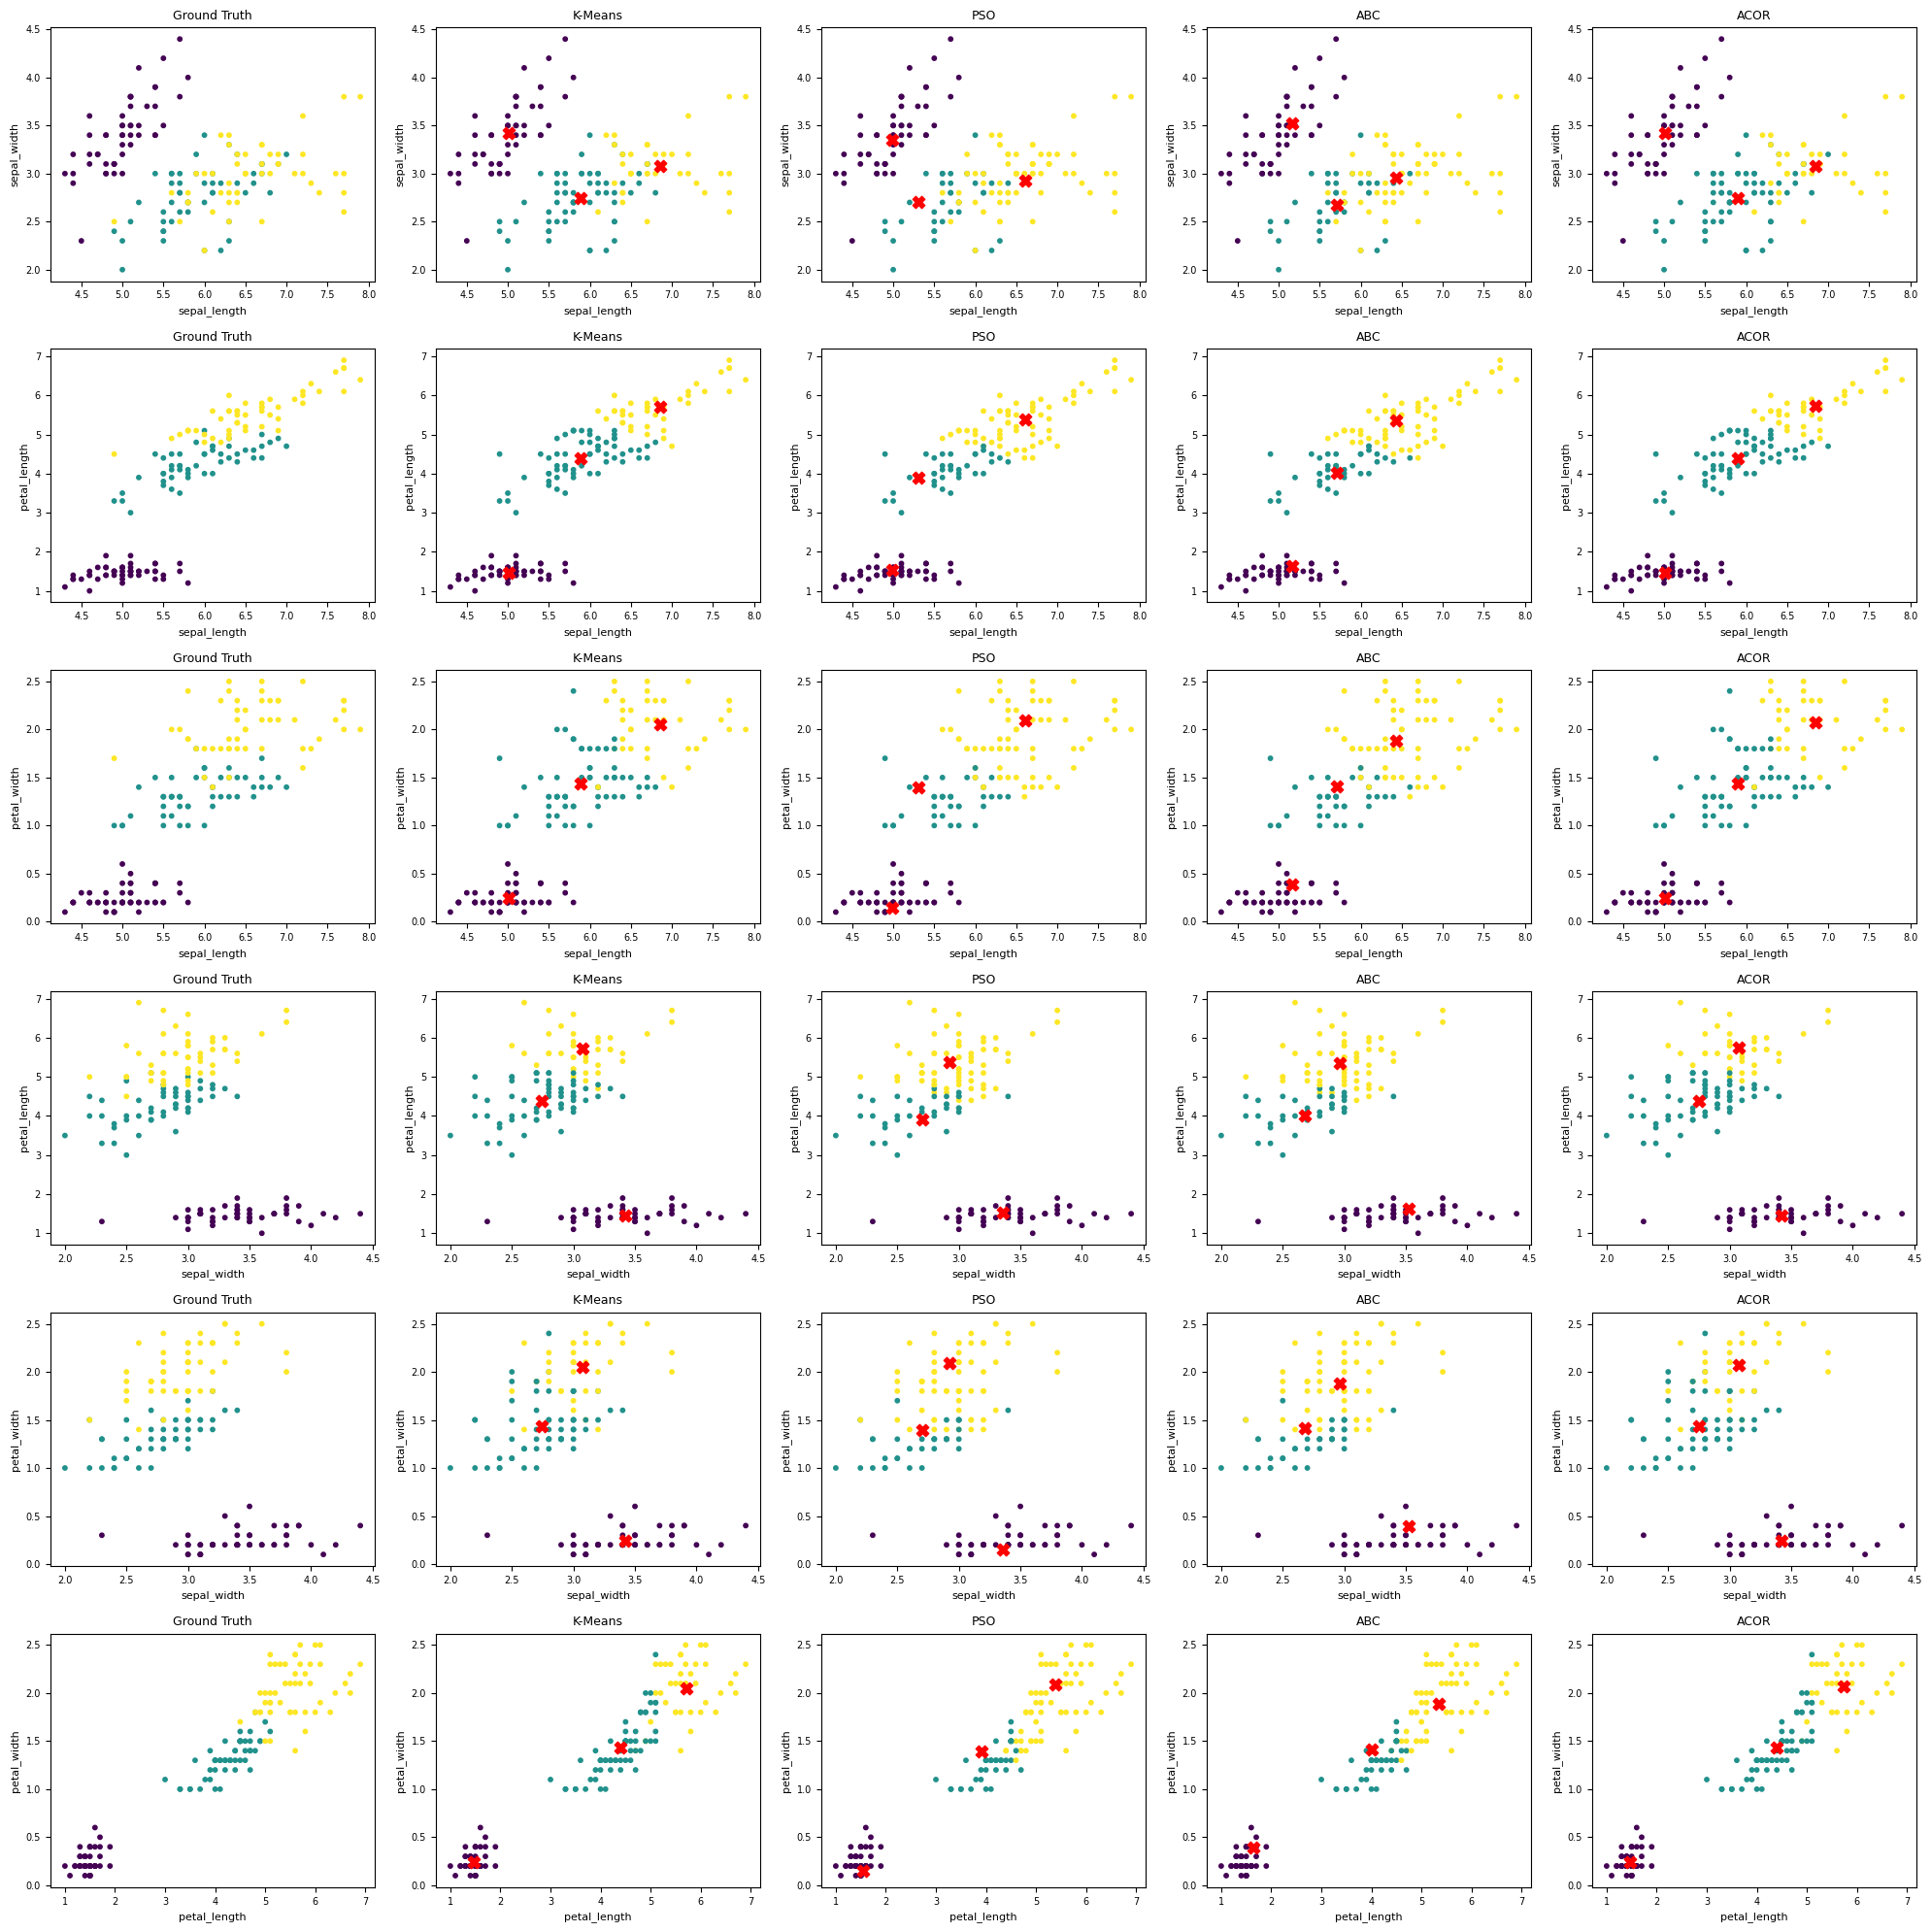

In [15]:
# Define all feature pairs and algorithms
feature_pairs = [
    (0, 1), (0, 2), (0, 3),
    (1, 2), (1, 3), (2, 3)
]
algorithms = [
    ("Ground Truth", true_labels, None),
    ("K-Means", translated_kmeans_labels, kmeans_centers),
    ("PSO", translated_pso_labels, pso_centers),
    ("ABC", translated_abc_labels, abc_centers),
    ("ACOR", translated_acor_labels, acor_centers)
]

# Feature names
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Create figure
plt.figure(figsize=(20, 20))

for i, (x_idx, y_idx) in enumerate(feature_pairs):
    for j, (name, labels, centers) in enumerate(algorithms):
        plt_idx = i * len(algorithms) + j + 1
        plt.subplot(len(feature_pairs), len(algorithms), plt_idx)
        plt.scatter(data_points[x_idx], data_points[y_idx], c=labels, cmap='viridis', s=10)

        if centers is not None:
            plt.scatter(centers[:, x_idx], centers[:, y_idx], c='red', s=80, marker='X')

        plt.title(name, fontsize=9)
        plt.xlabel(feature_names[x_idx], fontsize=8)
        plt.ylabel(feature_names[y_idx], fontsize=8)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()